In [41]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Bayesian inference of discontinuous composite model

The model has pdf 

$$
f(x) = \begin{cases}
pf_1(x)/F_1(\gamma)& \text{ if }x\leq \gamma \\
(1-p)f_2(x)/\overline{F}_2(\gamma)&\text{ if }x> \gamma
\end{cases},
$$
where $f_1$ is the gamma pdf with 

$$
f_1(x) = \frac{x^{r-1}e^{-x/m}}{\Gamma(r)m^r},\text{ } x>0
$$

and f_2 is the Pareto type 2 distribution with 

$$
f_2(x) = \frac{\alpha \gamma^\alpha}{x^{\alpha+1}}\text{ } x>\gamma
$$

The following method simulate data from this model

In [4]:
def sim_dis_gam_par(n, r, m, α, γ, p):
    """
    Sample from a discontinuous Gamma-Pareto model.

    Parameters
    ----------
    n : int 
        sample size.
    r : float
        shape parameter of the Gamma distribution.
    m : float
        scale parameter of the Gamma distribution.
    α : float
        Tail index of the Pareto distribution.
    γ : float
        Threshold parameter of the composite model.
    p: float
        mixing parameter of the composite model

    Returns
    -------
    array
    A sample drawn from the dicontinuous gamma-Pareto distribution.
    
    Example
    -------
    n, r, m, α, γ, p = 10, 2, 3, 1/2, 5, 1/3
    X = sim_dis_gam_par(n, r, m, α, γ, p)
    """    
    gamma_rv = st.gamma(r)
    par_rv = st.pareto(α)
    binom_rv =  st.binom(1, p)
    par_rvs = γ * par_rv.rvs(size = n)
    binom_rvs = binom_rv.rvs(size = n)
    gamma_rvs = m * gamma_rv.ppf(sp.gammainc(r, γ / m) *\
                               np.random.uniform(size = n))
    return(binom_rvs * gamma_rvs + (1 - binom_rvs) * par_rvs)

The following method provides the a computational tool for the log likelihood of the model

In [19]:
@nb.jit(nopython = True)
def reg_inc_gamma(a,x):
    """
    Compute the regularized incomplete gamma function.

    Parameters
    ----------
    a : float 
        parameter of the gamma function.
    x : float
        upper bound of the integral.

    Returns
    -------
    float
    Value of the regularized incomplete gamma function
    
    Example
    -------
    a, x = 3, 1 
    sp.gammainc(a, x),  reg_inc_gamma(a,x)
    """
    xam = -x + a * np.log(x)
    if x <= 1 + a:
        s = 1/a
        r = s
        for j in np.arange(1, 61, 1):
            r = r * x / (a + j)
            s = s + r
            if (abs(r /s) < 1e-15):
                break
        gin  = np.exp(xam) * s
        ga = ma.gamma(a)
        gip = gin / ga
        gim = ga - gin
    else:
        t0 = 0
        for j in np.flip(np.arange(1, 61, 1)):
            t0 = (j - a) / (1 + j / (x + t0))
        gim  = np.exp(xam) / (x + t0)
        ga = ma.gamma(a)
        gin = ga - gim
        gip = 1 - gim / ga
    return(gip)

def logp_dis_gam_par(X):
    """
    Likelihood function of the discontinuous Gamma-Pareto model.

    Parameters
    ----------
    X : Array 
        Insurance losses.

    Returns
    -------
    function
    Allows the evaluation of the likelihood in the parameters provided the 
    data.
    
    Example
    -------
    n, r, m, α, γ, p = 10, 2, 3, 1/2, 5, 1/3
    X = sim_dis_gam_par(n, r, m, α, γ, p)
    logp = logp_dis_gam_par(X)
    logp(np.array([2, 3, 1/2, 5, 1/3]))
    costFn = lambda parms: -logp(parms)
    bnds = ((0, None), (0, None), (0, None))
    θ0 = (1, 1, 1)
    minRes = minimize(costFn, θ0,bounds=bnds)
    minRes
    """
    def logp(parms):
        r, m, α, γ, p = parms
        
        if np.all(parms > 0):
            if p > 0 and p < 1:
                X1 = X[X < γ]
                X2 = X[X >= γ]
                F1 = reg_inc_gamma(r, γ / m)
                    
                return(len(X1) * (np.log(p) - np.log(F1) - np.log(ma.gamma(r)) - \
                                  r * np.log(m)) - np.sum(X1) / m +\
                       (r-1) * np.sum(np.log(X1)) + len(X2) *(np.log(1-p) +\
                        np.log(α) + α * np.log(γ)) - (α + 1) * np.sum(np.log(X2))
                       )
            else: 
                return(-np.inf)
            
        else:
            return(-np.inf)
    return nb.jit(nopython = True)(logp)

The model has 5 unknown parameters. The prior distributions setting are independant gamma and beta as follows

$$
p\sim \text{Beta}(a_p, b_p),\text{, }r\sim \text{Gamma}(a_r, b_r)\text{, }m\sim \text{Gamma}(a_m, b_m)\text{, }\alpha\sim \text{Gamma}(a_\alpha, b_\alpha)\text{, and }\gamma\sim \text{Gamma}(a_\gamma, b_\gamma)
$$

The following method samples from such a prior distribution

In [59]:
def sim_gamma_beta_prior(a, b, parms_names, popSize):
    """
    Sample from independent gamma priors and one beta prior.

    Parameters
    ----------
    a : array 
        shape hyperparameters.
    b : array
        scale hyperparameters.
    parms_names: array
        name of the parameters
    popSize: int
        sample size
        
    Returns
    -------
    dataframe
    Initialize parameters value from the independent 
    gamma prior distribution.
    
    Example
    -------
    a, b, parms_name, popSize   = [0.1, 0.1, 0.1], [10, 10, 10],\
        ['k','α', 'θ'], 10
    sim_gamma_prior(a, b, parms_name, popSize)
    """
    mat = [st.gamma(a[j]).rvs(popSize) / b[j] 
               for j in range(len(a)-1)]
    mat.append(st.beta(a[-1], b[-1]).rvs(popSize))
    res = pd.DataFrame(np.matrix(mat).transpose())
    res.columns = parms_names
    return res
 

In [110]:
np.dot((a_gammas - 1), np.log(gammas)), np.sum((a_gammas - 1) * np.log(gammas))

(27.963261207236364, 27.963261207236368)

In [113]:
def logp_gamma_beta_prior(a, b):
    """
    log probabilities of independent gamma priors and one beta prior.

    Parameters
    ----------
    a : array 
        shape hyperparameters.
    b : array
        scale hyperparameters.
    

    Returns
    -------
    function
    Allows to evaluate the log probabilities in the proposed parameters.
    
    Example
    -------
    """
    def logp_prior(parms):
        gammas, beta, a_gammas, a_beta, b_gammas, b_beta = parms[:len(parms)-1], parms[-1], a[:len(parms)-1], a[-1], b[:len(parms)-1], b[-1]
        if np.all(parms)>0 and beta < 1:
            l_gamma =  np.sum((a_gammas - 1) * np.log(gammas)) - np.sum(gammas * b_gammas) + np.sum(a_gammas * np.log(b_gammas)) - np.sum(np.log(np.array([ma.gamma( a_scalar ) for a_scalar in a_gammas])))
            l_beta = (a_beta - 1)*np.log(beta) + (b_beta - 1)*np.log(1 - beta) +  np.log(ma.gamma(a_beta)) + np.log(ma.gamma(b_beta)) - np.log(ma.gamma(a_beta + b_beta))

            return(l_gamma + l_beta)
        else:
            return(-np.inf)
    return nb.jit(nopython=True)(logp_prior)

In [114]:
parms_names = ["r","m", "α", "γ" , "p"]
a, b, popSize = np.append(0.1*np.ones(len(parms_names)-1), 2), np.append(0.1*np.ones(len(parms_names)-1), 2.0), 10
particle_cloud = sim_gamma_beta_prior(a, b, parms_names, popSize)
particles = particle_cloud.values
logp_prior = logp_gamma_beta_prior(a, b)
[logp_prior(parms) for parms in particles]

[13.205566501705341,
 28.26549297350392,
 -3.8847969362037413,
 3.953301411628827,
 42.7686106752453,
 -5.272158561529476,
 -3.1464087675467085,
 26.372636315832985,
 -4.080174959481209,
 -3.529625132051783]

In [117]:
@nb.jit(nopython=True)
def Gibbs_move(n_moves, step_size, log_prob, log_prob_prior, init_parms, γ, d):   
    """
    Function to perform Gibbs moves.

    Parameters
    ----------
    n_moves : int 
        number of moves.
    step_size: Array
        size of the steps in the MH within Gibbs move
    log_prob: function
        log likelihood function
    log_prob_prior: function
        log probability of the prior distribution
    init_parms: array
        initial value of the parameters
    γ: float
        Temperature
    d: int
        number of parameters
        
    Returns
    -------
    dataframe
    trace of each parameter and acceptance rate.
    
    Example
    -------
    k, α, θ = 1/2, 1/2, 5 
    X = sim_wei_par(100, k, α, θ)
    n_moves, step_size, log_prob, log_prob_prior, init_parms, γ, parms_names = 2, [0.05, 0.01, 2], \
    logp_wei_par(X), uniform_prior(np.array([0,0,0]), np.array([10,10,10])), np.array([1,1,1]), 1, ['k', 'α', 'θ']
    trace, acceptance = Gibbs_move(n_moves, step_size, log_prob, log_prob_prior, init_parms, γ, parms_names)
    """
    accepted_matrix = [np.repeat(False,d)]
   
    trace = [init_parms]
    

    # epsilon = np.random.multivariate_normal(mean = np.zeros(d), 
    #                                       cov = np.diag(step_size), size = n_moves)
    
    # for noise in np.atleast_2d(epsilon):
    for j in range(n_moves):
        parms_perturbed = trace[-1].copy()
        parms_new = trace[-1].copy()
        accepted = []
        for i in range(d):
            noise = np.random.normal(0, np.sqrt(step_size[i]))
            parms_perturbed[i] = parms_perturbed[i] + noise
            
            parms_new[i] = parms_perturbed[i]
            # acceptance rate
            old_log_p = γ * log_prob(trace[-1]) + log_prob_prior(trace[-1])
            new_log_p = γ * log_prob(parms_new) + log_prob_prior(parms_new)        
            ###
            acc =  new_log_p - old_log_p 
            ###       
            if np.log(np.random.rand()) < acc:
                parms_new[i] = parms_perturbed[i]
                accepted.append(True)
            else:
                parms_new[i] = trace[-1][i]
                # np.put(parms_new, i, trace[-1][i])
                accepted.append(False)
        trace.append(parms_new) 
        accepted_matrix.append(np.array(accepted))
                
     
    return(trace, accepted_matrix)

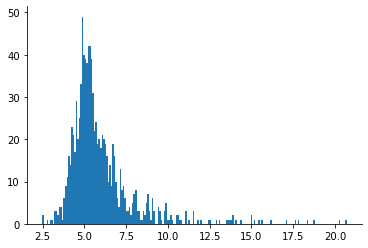

In [141]:
n, r, m, α, γ, p = 1000, 10, 3, 4, 5, 1/3
true_parms = np.array([r, m, α, γ, p])
X = sim_dis_gam_par(n, r, m, α, γ, p)
plt.hist(X,bins=200)
sns.despine()

In [151]:
n_moves, step_size, log_prob, log_prob_prior, init_parms, τ, d = 15000, np.array([2.70530558e+00, 3.63055785e+01, 2.76341899e-02, 9.39764106e-03,
       2.27288158e-03]), logp_dis_gam_par(X), logp_gamma_beta_prior(a, b), particles[0], 1, len(particles[0])
trace, acceptance = Gibbs_move(n_moves, step_size, log_prob, log_prob_prior, init_parms, τ, d)
trace_gibbs = pd.DataFrame(trace).iloc[int(n_moves / 2):]
trace_gibbs.columns = parms_names

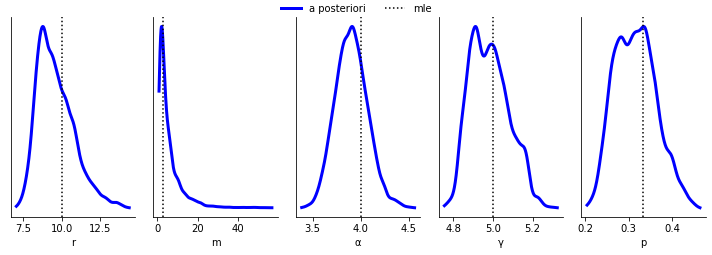

In [152]:
fig, axs = plt.subplots(1, len(parms_names), figsize=(10, 3.5))
x_labs = parms_names
for k in range(len(x_labs)):
    positions = np.linspace(min(trace_gibbs[parms_names[k]]), max(trace_gibbs[parms_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_gibbs[parms_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")

    axs[k].axvline(true_parms[k], color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
#     axs[k].set_xticks(np.round(
#         trace_gibbs[parms_names[k]].quantile([0.05, 0.95]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()

In [148]:
np.diag(trace_gibbs.cov().values)

array([2.70530558e+00, 3.63055785e+01, 2.76341899e-02, 9.39764106e-03,
       2.27288158e-03])